Azure On-Time Flight Arrivals Analysis

In [1]:
!curl https://topcs.blob.core.windows.net/public/FlightData.csv -o flightdata.csv

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 1552k  100 1552k    0     0  1861k      0 --:--:-- --:--:-- --:--:-- 1861k


In [2]:
import pandas as pd

df = pd.read_csv('flightdata.csv')
df.head()

,YEAR,QUARTER,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,UNIQUE_CARRIER,TAIL_NUM,FL_NUM,ORIGIN_AIRPORT_ID,ORIGIN,...,CRS_ARR_TIME,ARR_TIME,ARR_DELAY,ARR_DEL15,CANCELLED,DIVERTED,CRS_ELAPSED_TIME,ACTUAL_ELAPSED_TIME,DISTANCE,Unnamed: 25
0,2016,1,1,1,5,DL,N836DN,1399,10397,ATL,...,2143,2102.0,-41.0,0.0,0.0,0.0,338.0,295.0,2182.0,NaN
1,2016,1,1,1,5,DL,N964DN,1476,11433,DTW,...,1435,1439.0,4.0,0.0,0.0,0.0,110.0,115.0,528.0,NaN
2,2016,1,1,1,5,DL,N813DN,1597,10397,ATL,...,1215,1142.0,-33.0,0.0,0.0,0.0,335.0,300.0,2182.0,NaN
3,2016,1,1,1,5,DL,N587NW,1768,14747,SEA,...,1335,1345.0,10.0,0.0,0.0,0.0,196.0,205.0,1399.0,NaN
4,2016,1,1,1,5,DL,N836DN,1823,14747,SEA,...,607,615.0,8.0,0.0,0.0,0.0,247.0,259.0,1927.0,NaN


In [3]:
df.shape

(11231, 26)

Data Preparation

In [8]:
df.isnull().values.any()

True

In [9]:
df.isnull().sum()

YEAR                     0
QUARTER                  0
MONTH                    0
DAY_OF_MONTH             0
DAY_OF_WEEK              0
UNIQUE_CARRIER           0
TAIL_NUM                 0
FL_NUM                   0
ORIGIN_AIRPORT_ID        0
ORIGIN                   0
DEST_AIRPORT_ID          0
DEST                     0
CRS_DEP_TIME             0
DEP_TIME               107
DEP_DELAY              107
DEP_DEL15              107
CRS_ARR_TIME             0
ARR_TIME               115
ARR_DELAY              188
ARR_DEL15              188
CANCELLED                0
DIVERTED                 0
CRS_ELAPSED_TIME         0
ACTUAL_ELAPSED_TIME    188
DISTANCE                 0
dtype: int64

The unnamed column can be dropped. 

In [ ]:
df = df.drop('Unnamed: 25', axis=1)
df.isnull().sum()

Here is key information for us to understand the data.

Here is a complete list of the columns in the dataset. Times are expressed in 24-hour military time. For example, 1130 equals 11:30 a.m. and 1500 equals 3:00 p.m.

TABLE 1
Column	Description
YEAR	Year that the flight took place
QUARTER	Quarter that the flight took place (1-4)
MONTH	Month that the flight took place (1-12)
DAY_OF_MONTH	Day of the month that the flight took place (1-31)
DAY_OF_WEEK	Day of the week that the flight took place (1=Monday, 2=Tuesday, etc.)
UNIQUE_CARRIER	Airline carrier code (e.g., DL)
TAIL_NUM	Aircraft tail number
FL_NUM	Flight number
ORIGIN_AIRPORT_ID	ID of the airport of origin
ORIGIN	Origin airport code (ATL, DFW, SEA, etc.)
DEST_AIRPORT_ID	ID of the destination airport
DEST	Destination airport code (ATL, DFW, SEA, etc.)
CRS_DEP_TIME	Scheduled departure time
DEP_TIME	Actual departure time
DEP_DELAY	Number of minutes departure was delayed
DEP_DEL15	0=Departure delayed less than 15 minutes, 1=Departure delayed 15 minutes or more
CRS_ARR_TIME	Scheduled arrival time
ARR_TIME	Actual arrival time
ARR_DELAY	Number of minutes flight arrived late
ARR_DEL15	0=Arrived less than 15 minutes late, 1=Arrived 15 minutes or more late
CANCELLED	0=Flight was not cancelled, 1=Flight was cancelled
DIVERTED	0=Flight was not diverted, 1=Flight was diverted
CRS_ELAPSED_TIME	Scheduled flight time in minutes
ACTUAL_ELAPSED_TIME	Actual flight time in minutes
DISTANCE	Distance traveled in miles
The dataset includes a roughly even distribution of dates throughout the year, which is important because a flight out of Minneapolis is less likely to be delayed due to winter storms in July than it is in January.

After consulting our SME, here are the relevant insights:
-the aircraft's tail number probably has little bearing on whether a flight will arrive on time
-at the time you book a ticket, you have no way of knowing whether a flight will be cancelled, diverted, or delayed
-By contrast, the scheduled departure time could have a lot to do with on-time arrivals
-Because of the hub-and-spoke system used by most airlines, morning flights tend to be on time more often than afternoon or evening flights
-at some major airports, traffic stacks up during the day, increasing the likelihood that later flights will be delayed.

In [10]:
df = df[["MONTH", "DAY_OF_MONTH", "DAY_OF_WEEK", "ORIGIN", "DEST", "CRS_DEP_TIME", "ARR_DEL15"]]
df.isnull().sum()

MONTH             0
DAY_OF_MONTH      0
DAY_OF_WEEK       0
ORIGIN            0
DEST              0
CRS_DEP_TIME      0
ARR_DEL15       188
dtype: int64

In [11]:
df[df.isnull().values.any(axis=1)].head()

,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,ORIGIN,DEST,CRS_DEP_TIME,ARR_DEL15
177,1,9,6,MSP,SEA,701,NaN
179,1,10,7,MSP,DTW,1348,NaN
184,1,10,7,MSP,DTW,625,NaN
210,1,10,7,DTW,MSP,1200,NaN
478,1,22,5,SEA,JFK,2305,NaN


Recall this is a categorical variable where 0 is for flights late by less than 15 minutes and 1 is for flights late by more than 15 minutes. Instead of dropping these ~200 records, let's assume they were all late by more than 15 minutes.

In [12]:
df = df.fillna({'ARR_DEL15': 1})
df.iloc[177:185]

,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,ORIGIN,DEST,CRS_DEP_TIME,ARR_DEL15
177,1,9,6,MSP,SEA,701,1.0
178,1,9,6,DTW,JFK,1527,0.0
179,1,10,7,MSP,DTW,1348,1.0
180,1,10,7,DTW,MSP,1540,0.0
181,1,10,7,JFK,ATL,1325,0.0
182,1,10,7,JFK,ATL,610,0.0
183,1,10,7,JFK,SEA,1615,0.0
184,1,10,7,MSP,DTW,625,1.0


The dataset has been cleaned.  However it is not fully prepared for analysis.

The CRS_DEP_TIME column of the dataset you are using represents scheduled departure times. The granularity of the numbers in this column — it contains more than 500 unique values — could have a negative impact on accuracy in a machine-learning model. This can be resolved using a technique called binning or quantization. What if you divided each number in this column by 100 and rounded down to the nearest integer? 1030 would become 10, 1925 would become 19, and so on, and you would be left with a maximum of 24 discrete values in this column. Intuitively, it makes sense, because it probably doesn't matter much whether a flight leaves at 10:30 a.m. or 10:40 a.m. It matters a great deal whether it leaves at 10:30 a.m. or 5:30 p.m.

In addition, the dataset's ORIGIN and DEST columns contain airport codes that represent categorical machine-learning values. These columns need to be converted into discrete columns containing indicator variables, sometimes known as "dummy" variables. In other words, the ORIGIN column, which contains five airport codes, needs to be converted into five columns, one per airport, with each column containing 1s and 0s indicating whether a flight originated at the airport that the column represents. The DEST column needs to be handled in a similar manner.

In [13]:
df.head()

,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,ORIGIN,DEST,CRS_DEP_TIME,ARR_DEL15
0,1,1,5,ATL,SEA,1905,0.0
1,1,1,5,DTW,MSP,1345,0.0
2,1,1,5,ATL,SEA,940,0.0
3,1,1,5,SEA,MSP,819,0.0
4,1,1,5,SEA,DTW,2300,0.0


In [18]:
df['CRS_DEP_TIME'].unique()

array([19, 13,  9,  8, 23, 11, 17, 14,  7, 16, 15, 20,  6, 12, 10, 22, 18,
       21,  5,  0,  1])

The departure time needs to be converted to hours due to the hgh volume of unique values

In [14]:
import math

for index, row in df.iterrows():
    df.loc[index, 'CRS_DEP_TIME'] = math.floor(row['CRS_DEP_TIME'] / 100)
df.head()

,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,ORIGIN,DEST,CRS_DEP_TIME,ARR_DEL15
0,1,1,5,ATL,SEA,19,0.0
1,1,1,5,DTW,MSP,13,0.0
2,1,1,5,ATL,SEA,9,0.0
3,1,1,5,SEA,MSP,8,0.0
4,1,1,5,SEA,DTW,23,0.0


The origin and destination airports need to be converted into dummy variables for machine learning.

In [19]:
df = pd.get_dummies(df, columns=['ORIGIN', 'DEST'])
df.head()

,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,CRS_DEP_TIME,ARR_DEL15,ORIGIN_ATL,ORIGIN_DTW,ORIGIN_JFK,ORIGIN_MSP,ORIGIN_SEA,DEST_ATL,DEST_DTW,DEST_JFK,DEST_MSP,DEST_SEA
0,1,1,5,19,0.0,1,0,0,0,0,0,0,0,0,1
1,1,1,5,13,0.0,0,1,0,0,0,0,0,0,1,0
2,1,1,5,9,0.0,1,0,0,0,0,0,0,0,0,1
3,1,1,5,8,0.0,0,0,0,0,1,0,0,0,1,0
4,1,1,5,23,0.0,0,0,0,0,1,0,1,0,0,0


Data Analysis

Let's begin by dividing the dataset into a training and test set.

In [20]:
from sklearn.model_selection import train_test_split
train_x, test_x, train_y, test_y = train_test_split(df.drop('ARR_DEL15', axis=1), df['ARR_DEL15'], test_size=0.2, random_state=42)

In [21]:
train_x.shape

(8984, 14)

In [22]:
test_x.shape

(2247, 14)

Let's apply a random forest classifier model to the training data.

In [23]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(random_state=13)
model.fit(train_x, train_y)

/anaconda/envs/azureml_py36/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=13, verbose=0, warm_start=False)

In [24]:
predicted = model.predict(test_x)
model.score(test_x, test_y)

0.8602581219403649

The mean accuracy is 86%.  So what?  Let's use AUC as our measure instead.

In [25]:
from sklearn.metrics import roc_auc_score
probabilities = model.predict_proba(test_x)

In [26]:
roc_auc_score(test_y, probabilities[:, 1])

0.6743824904998539

In [27]:
from sklearn.metrics import confusion_matrix
confusion_matrix(test_y, predicted)

array([[1882,   54],
       [ 260,   51]])

In [28]:
from sklearn.metrics import precision_score

train_predictions = model.predict(train_x)
precision_score(train_y, train_predictions)

0.9972375690607734

In [29]:
from sklearn.metrics import recall_score

recall_score(train_y, train_predictions)

0.8650159744408946

Data Visualization

In [30]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()

Text(0, 0.5, 'True Positive Rate')

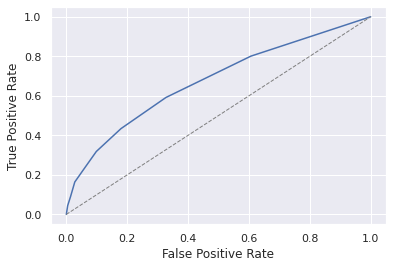

In [31]:
from sklearn.metrics import roc_curve

fpr, tpr, _ = roc_curve(test_y, probabilities[:, 1])
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], color='grey', lw=1, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

In [32]:
def predict_delay(departure_date_time, origin, destination):
    from datetime import datetime

    try:
        departure_date_time_parsed = datetime.strptime(departure_date_time, '%d/%m/%Y %H:%M:%S')
    except ValueError as e:
        return 'Error parsing date/time - {}'.format(e)

    month = departure_date_time_parsed.month
    day = departure_date_time_parsed.day
    day_of_week = departure_date_time_parsed.isoweekday()
    hour = departure_date_time_parsed.hour

    origin = origin.upper()
    destination = destination.upper()

    input = [{'MONTH': month,
              'DAY': day,
              'DAY_OF_WEEK': day_of_week,
              'CRS_DEP_TIME': hour,
              'ORIGIN_ATL': 1 if origin == 'ATL' else 0,
              'ORIGIN_DTW': 1 if origin == 'DTW' else 0,
              'ORIGIN_JFK': 1 if origin == 'JFK' else 0,
              'ORIGIN_MSP': 1 if origin == 'MSP' else 0,
              'ORIGIN_SEA': 1 if origin == 'SEA' else 0,
              'DEST_ATL': 1 if destination == 'ATL' else 0,
              'DEST_DTW': 1 if destination == 'DTW' else 0,
              'DEST_JFK': 1 if destination == 'JFK' else 0,
              'DEST_MSP': 1 if destination == 'MSP' else 0,
              'DEST_SEA': 1 if destination == 'SEA' else 0 }]

    return model.predict_proba(pd.DataFrame(input))[0][0]

In [33]:
predict_delay('1/10/2018 21:45:00', 'JFK', 'ATL')

0.6

In [34]:
predict_delay('2/10/2018 21:45:00', 'JFK', 'ATL')

0.8

In [35]:
predict_delay('2/10/2018 10:00:00', 'ATL', 'SEA')

1.0

(0.0, 1.0)

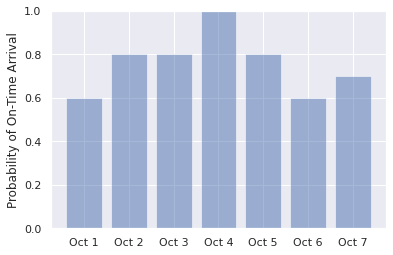

In [36]:
import numpy as np

labels = ('Oct 1', 'Oct 2', 'Oct 3', 'Oct 4', 'Oct 5', 'Oct 6', 'Oct 7')
values = (predict_delay('1/10/2018 21:45:00', 'JFK', 'ATL'),
          predict_delay('2/10/2018 21:45:00', 'JFK', 'ATL'),
          predict_delay('3/10/2018 21:45:00', 'JFK', 'ATL'),
          predict_delay('4/10/2018 21:45:00', 'JFK', 'ATL'),
          predict_delay('5/10/2018 21:45:00', 'JFK', 'ATL'),
          predict_delay('6/10/2018 21:45:00', 'JFK', 'ATL'),
          predict_delay('7/10/2018 21:45:00', 'JFK', 'ATL'))
alabels = np.arange(len(labels))

plt.bar(alabels, values, align='center', alpha=0.5)
plt.xticks(alabels, labels)
plt.ylabel('Probability of On-Time Arrival')
plt.ylim((0.0, 1.0))

(0.0, 1.0)

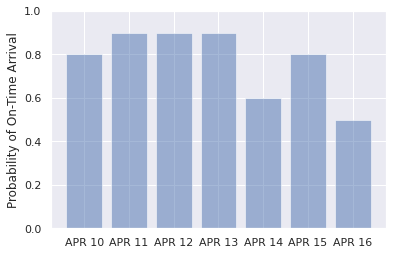

In [39]:
import numpy as np

labels = ('APR 10', 'APR 11', 'APR 12', 'APR 13', 'APR 14', 'APR 15', 'APR 16')
values = (predict_delay('10/4/2018 13:00:00', 'JFK', 'MSP'),
          predict_delay('11/4/2018 13:00:00', 'JFK', 'MSP'),
          predict_delay('12/4/2018 13:00:00', 'JFK', 'MSP'),
          predict_delay('13/4/2018 13:00:00', 'JFK', 'MSP'),
          predict_delay('14/4/2018 13:00:00', 'JFK', 'MSP'),
          predict_delay('15/4/2018 13:00:00', 'JFK', 'MSP'),
          predict_delay('16/4/2018 13:00:00', 'JFK', 'MSP'))
alabels = np.arange(len(labels))

plt.bar(alabels, values, align='center', alpha=0.5)
plt.xticks(alabels, labels)
plt.ylabel('Probability of On-Time Arrival')
plt.ylim((0.0, 1.0))

(0.0, 1.0)

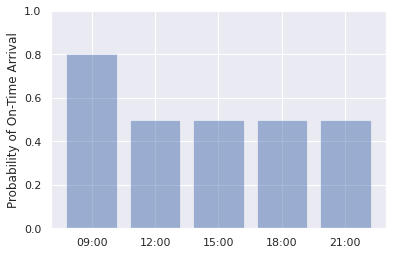

In [49]:
import numpy as np

labels = ('09:00', '12:00', '15:00', '18:00', '21:00')
values = (predict_delay('30/1/2018 09:00:00', 'SEA', 'ATL'),
          predict_delay('30/1/2018 12:00:00', 'SEA', 'ATL'),
          predict_delay('30/1/2018 15:00:00', 'SEA', 'ATL'),
          predict_delay('30/1/2018 18:00:00', 'SEA', 'ATL'),
          predict_delay('30/1/2018 21:00:00', 'SEA', 'ATL'))
          #,predict_delay('30/1/2018 13:00:00', 'SEA', 'ATL')
          #,predict_delay('30/1/2018 13:00:00', 'SEA', 'ATL'))
alabels = np.arange(len(labels))

plt.bar(alabels, values, align='center', alpha=0.5)
plt.xticks(alabels, labels)
plt.ylabel('Probability of On-Time Arrival')
plt.ylim((0.0, 1.0))

Finito